# Import packages et fonctions

In [156]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import itertools

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import IntegerType, ArrayType, StructType
import pyspark.sql.functions as F

from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler,StandardScaler, IndexToString, VectorIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, MultilayerPerceptronClassifier, RandomForestClassifier, MultilayerPerceptronClassifier, DecisionTreeClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

In [8]:
def evaluate_prediction(predictions):
    class_names=[1.0,0.0]
    def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        
    y_true = predictions.select("label")
    y_true = y_true.toPandas()

    y_pred = predictions.select("prediction")
    y_pred = y_pred.toPandas()

    cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
    #cnf_matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix')
    plt.show()

# Transform datafram letter into number.

In [9]:
spark = SparkSession.builder.appName('Mushrooms').getOrCreate()
df = spark.read.csv('mushrooms.csv',header=True,inferSchema=True)
df.show()

+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|class|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|spore-print-color|population|habitat|
+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|    p|        x|          s|        n|      t|   p|              f|           c|        n|   

In [10]:
df = (df
      .withColumnRenamed('class', 'Class')
      .withColumnRenamed('cap-shape', 'cap_shape')
      .withColumnRenamed('cap-surface', 'cap_surface')
      .withColumnRenamed('cap-color', 'cap_color')
      .withColumnRenamed('gill-attachment', 'gill_attachment')
      .withColumnRenamed('gill-spacing', 'gill_spacing')
      .withColumnRenamed('gill-size', 'gill_size')
      .withColumnRenamed('gill-color', 'gill_color')
      .withColumnRenamed('stalk-shape', 'stalk_shape')
      .withColumnRenamed('stalk-root', 'stalk_root')
      .withColumnRenamed('stalk-surface-above-ring', 'stalk_surface_above_ring')
      .withColumnRenamed('stalk-surface-below-ring', 'stalk_surface_below_ring')
      .withColumnRenamed('stalk-color-above-ring', 'stalk_color_above_ring')
      .withColumnRenamed('stalk-color-below-ring', 'stalk_color_below_ring')
      .withColumnRenamed('veil_type', 'veil_type')
      .withColumnRenamed('veil-color', 'veil_color')
      .withColumnRenamed('ring-number', 'ring_number')
      .withColumnRenamed('ring-type', 'ring_type')
      .withColumnRenamed('spore-print-color', 'spore_print_color')
)

In [11]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns ]

pipeline = Pipeline(stages=indexers)
df_pipeline = pipeline.fit(df).transform(df)

df_prepared = df_pipeline.select([col for col in df_pipeline.columns if col[-6:] == "_index"])
df_prepared = df_prepared.withColumnRenamed('class_index','label')
df_prepared.show()

+-----+---------------+-----------------+---------------+-------------+----------+---------------------+------------------+---------------+----------------+-----------------+----------------+------------------------------+------------------------------+----------------------------+----------------------------+---------------+----------------+-----------------+---------------+-----------------------+----------------+-------------+
|label|cap_shape_index|cap_surface_index|cap_color_index|bruises_index|odor_index|gill_attachment_index|gill_spacing_index|gill_size_index|gill_color_index|stalk_shape_index|stalk_root_index|stalk_surface_above_ring_index|stalk_surface_below_ring_index|stalk_color_above_ring_index|stalk_color_below_ring_index|veil-type_index|veil_color_index|ring_number_index|ring_type_index|spore_print_color_index|population_index|habitat_index|
+-----+---------------+-----------------+---------------+-------------+----------+---------------------+------------------+---------

In [12]:
df_prepared.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 4208|
|  1.0| 3916|
+-----+-----+



# Prepare each row into vectors.  

In [13]:
features = [ i for i in df_prepared.columns if i != "label"]
features

['cap_shape_index',
 'cap_surface_index',
 'cap_color_index',
 'bruises_index',
 'odor_index',
 'gill_attachment_index',
 'gill_spacing_index',
 'gill_size_index',
 'gill_color_index',
 'stalk_shape_index',
 'stalk_root_index',
 'stalk_surface_above_ring_index',
 'stalk_surface_below_ring_index',
 'stalk_color_above_ring_index',
 'stalk_color_below_ring_index',
 'veil-type_index',
 'veil_color_index',
 'ring_number_index',
 'ring_type_index',
 'spore_print_color_index',
 'population_index',
 'habitat_index']

In [14]:
vectorizor = (VectorAssembler()
             .setInputCols(features)
             .setOutputCol("vectorized_features"))

vectorized_df=vectorizor.transform(df_prepared)
vectorized_df.select('vectorized_features','label').show(20, False)

23/02/03 10:13:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------------------------------------------------------+-----+
|vectorized_features                                                           |label|
+------------------------------------------------------------------------------+-----+
|(22,[1,3,4,7,8,9,10,19,20,21],[1.0,1.0,6.0,1.0,7.0,1.0,2.0,2.0,2.0,4.0])      |1.0  |
|(22,[1,2,3,4,8,9,10,19,20,21],[1.0,3.0,1.0,4.0,7.0,1.0,3.0,1.0,3.0,1.0])      |0.0  |
|(22,[0,1,2,3,4,8,9,10,19,20,21],[3.0,1.0,4.0,1.0,5.0,3.0,1.0,3.0,1.0,3.0,5.0])|0.0  |
|(22,[2,3,4,7,8,9,10,19,20,21],[4.0,1.0,6.0,1.0,3.0,1.0,2.0,2.0,2.0,4.0])      |1.0  |
|(22,[1,2,6,8,10,18,19,20,21],[1.0,1.0,1.0,7.0,2.0,1.0,1.0,4.0,1.0])           |0.0  |
|(22,[2,3,4,8,9,10,19,20,21],[3.0,1.0,4.0,3.0,1.0,3.0,2.0,3.0,1.0])            |0.0  |
|(22,[0,1,2,3,4,8,9,10,19,20,21],[3.0,1.0,4.0,1.0,4.0,4.0,1.0,3.0,2.0,3.0,5.0])|0.0  |
|(22,[0,2,3,4,8,9,10,19,20,21],[3.0,4.0,1.0,5.0,3.0,1.0,3.0,1.0,2.0,5.0])      |0.0  |
|(22,[2,3,4,7,8,9,10,19,21],[4.0,1.0,6.0,1.

# Split data & models training

In [15]:
(train, test) = vectorized_df.randomSplit([0.8, 0.2], seed = 2)
train.count(), test.count()

(6584, 1540)

+-----+--------------------------------------------+----------+------------------------------------------+
|label|rawPrediction                               |prediction|probability                               |
+-----+--------------------------------------------+----------+------------------------------------------+
|1.0  |[28.433743407402766,-28.433743407402766]    |0.0       |[0.9999999999995519,4.480860127387132E-13]|
|1.0  |[1.5882037923759498,-1.5882037923759498]    |0.0       |[0.8303632391438334,0.16963676085616664]  |
|1.0  |[1.5720055722493438,-1.5720055722493438]    |0.0       |[0.8280693305188418,0.1719306694811582]   |
|1.0  |[0.8501730443634319,-0.8501730443634319]    |0.0       |[0.7006034412183988,0.2993965587816012]   |
|1.0  |[0.7327408334482737,-0.7327408334482737]    |0.0       |[0.6754064412129686,0.32459355878703144]  |
|1.0  |[0.7036427905471623,-0.7036427905471623]    |0.0       |[0.6689949303107446,0.33100506968925536]  |
|1.0  |[0.5277254757498859,-0.5277254

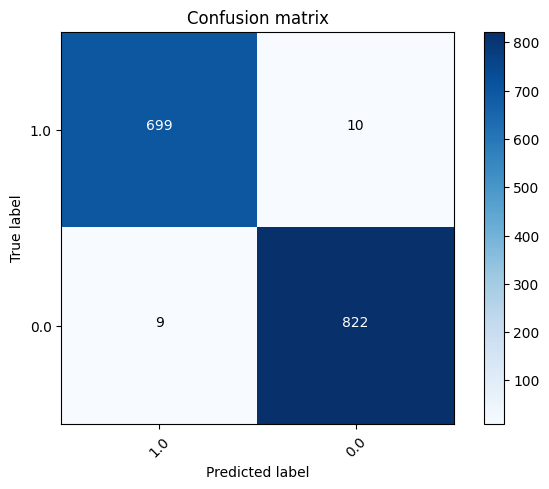

In [16]:
lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'label', maxIter=100, aggregationDepth=2)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').filter('label=1' ).orderBy(F.col('probability').desc()).show(20, False)
evaluate_prediction(predictions)

+-----+-------------+----------+-----------+
|label|rawPrediction|prediction|probability|
+-----+-------------+----------+-----------+
|0.0  |[57.0,0.0]   |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
+-----+-------------+----------+-----------+
only showing top 10 rows

Confusion matrix, without normalization
[[709   0]
 [  0 831]]


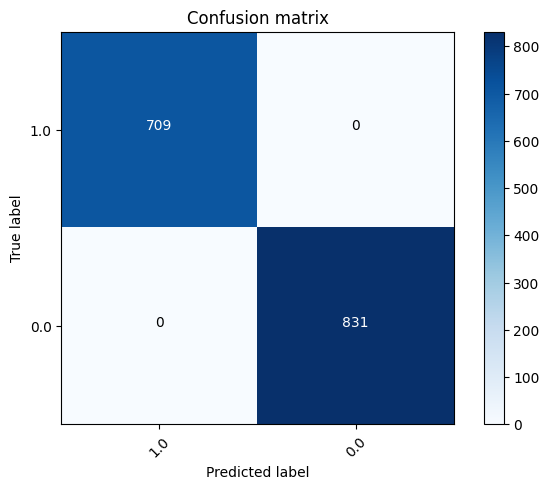

In [17]:
dt = DecisionTreeClassifier(featuresCol = 'vectorized_features', labelCol = 'label', maxDepth=10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
#predictions_train = dtModel.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10, False)
evaluate_prediction(predictions)

+-----+---------------------------------------+----------+-----------------------------------------+
|label|rawPrediction                          |prediction|probability                              |
+-----+---------------------------------------+----------+-----------------------------------------+
|0.0  |[8.734953907986093,1.265046092013907]  |0.0       |[0.8734953907986093,0.1265046092013907]  |
|0.0  |[9.603205649841088,0.3967943501589116] |0.0       |[0.9603205649841089,0.03967943501589116] |
|0.0  |[9.888371890250296,0.11162810974970441]|0.0       |[0.9888371890250296,0.011162810974970442]|
|0.0  |[9.920594112472518,0.07940588752748219]|0.0       |[0.9920594112472518,0.00794058875274822] |
|0.0  |[9.888371890250296,0.11162810974970441]|0.0       |[0.9888371890250296,0.011162810974970442]|
+-----+---------------------------------------+----------+-----------------------------------------+
only showing top 5 rows

Confusion matrix, without normalization
[[708   1]
 [  0 831]]


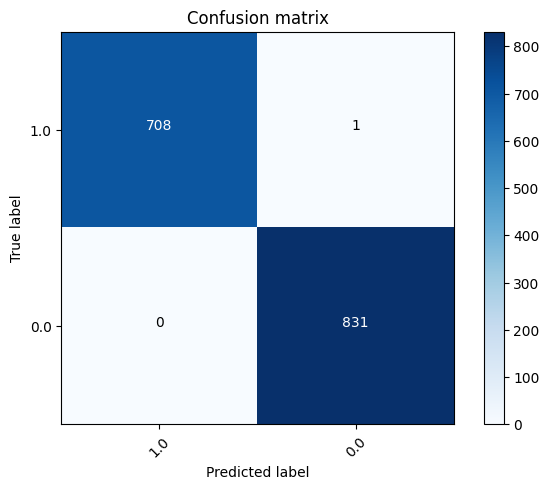

In [18]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'vectorized_features', labelCol = 'label', numTrees=10)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
#predictions_train = rfModel.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(5, False)

evaluate_prediction(predictions)


+-----+----------------------------------------+----------+-----------------------------------------+
|label|rawPrediction                           |prediction|probability                              |
+-----+----------------------------------------+----------+-----------------------------------------+
|0.0  |[1.6587994527013081,-1.6587994527013081]|0.0       |[0.9650276466554236,0.03497235334457638] |
|0.0  |[1.8617318065762856,-1.8617318065762856]|0.0       |[0.9764193020534142,0.023580697946585794]|
|0.0  |[1.8617318065762856,-1.8617318065762856]|0.0       |[0.9764193020534142,0.023580697946585794]|
|0.0  |[1.8617318065762856,-1.8617318065762856]|0.0       |[0.9764193020534142,0.023580697946585794]|
|0.0  |[1.8617318065762856,-1.8617318065762856]|0.0       |[0.9764193020534142,0.023580697946585794]|
+-----+----------------------------------------+----------+-----------------------------------------+
only showing top 5 rows

Confusion matrix, without normalization
[[709   0]
 [  0 

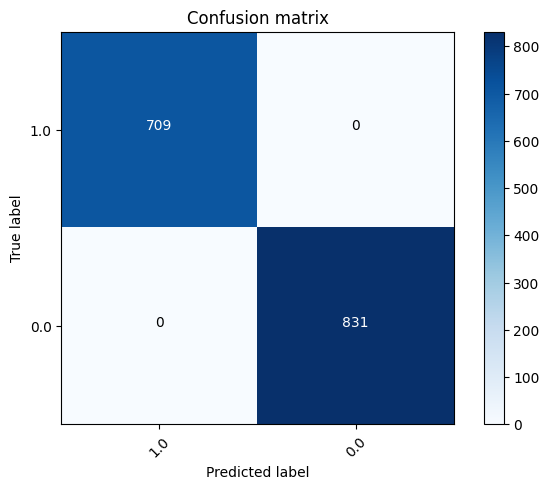

In [21]:
from pyspark.ml.classification import GBTClassifier

rf = GBTClassifier(labelCol="label", featuresCol="vectorized_features", maxIter=45)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
#predictions_train = rfModel.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(5, False)
evaluate_prediction(predictions)


# FULL FIT and save best model

* Je garde DecisionTreeClassifier, il a eu un score à 1 et il est plus rapide à s'entrainer que GBTClassifier. 

In [56]:
df = spark.read.csv('mushrooms.csv',header=True,inferSchema=True)
df.columns

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [129]:
df = spark.read.csv('mushrooms.csv',header=True,inferSchema=True)
df = (df
      .withColumnRenamed('class', 'Class')
      .withColumnRenamed('cap-shape', 'cap_shape')
      .withColumnRenamed('cap-surface', 'cap_surface')
      .withColumnRenamed('cap-color', 'cap_color')
      .withColumnRenamed('gill-attachment', 'gill_attachment')
      .withColumnRenamed('gill-spacing', 'gill_spacing')
      .withColumnRenamed('gill-size', 'gill_size')
      .withColumnRenamed('gill-color', 'gill_color')
      .withColumnRenamed('stalk-shape', 'stalk_shape')
      .withColumnRenamed('stalk-root', 'stalk_root')
      .withColumnRenamed('stalk-surface-above-ring', 'stalk_surface_above_ring')
      .withColumnRenamed('stalk-surface-below-ring', 'stalk_surface_below_ring')
      .withColumnRenamed('stalk-color-above-ring', 'stalk_color_above_ring')
      .withColumnRenamed('stalk-color-below-ring', 'stalk_color_below_ring')
      .withColumnRenamed('veil-type', 'veil_type')
      .withColumnRenamed('veil-color', 'veil_color')
      .withColumnRenamed('ring-number', 'ring_number')
      .withColumnRenamed('ring-type', 'ring_type')
      .withColumnRenamed('spore-print-color', 'spore_print_color')
)
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns ]

pipeline = Pipeline(stages=indexers)
df_pipeline = pipeline.fit(df).transform(df)

df_prepared = df_pipeline.select([col for col in df_pipeline.columns if col[-6:] == "_index"])
df_prepared = df_prepared.withColumnRenamed('Class_index','label')
features = [ i for i in df_prepared.columns if i != "label"]
vectorizor = (VectorAssembler()
             .setInputCols(features)
             .setOutputCol("vectorized_features"))

vectorized_df=vectorizor.transform(df_prepared)
(train, test) = vectorized_df.randomSplit([0.8, 0.2], seed = 2)
print('size train: ', train.count(), 'size_test ', test.count())

dt = DecisionTreeClassifier(featuresCol = 'vectorized_features', labelCol = 'label', maxDepth=10)
dtModel = dt.fit(train)

size train:  6584 size_test  1540


+-----+-------------+----------+-----------+
|label|rawPrediction|prediction|probability|
+-----+-------------+----------+-----------+
|0.0  |[57.0,0.0]   |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3160.0,0.0] |0.0       |[1.0,0.0]  |
+-----+-------------+----------+-----------+
only showing top 10 rows

Confusion matrix, without normalization
[[709   0]
 [  0 831]]


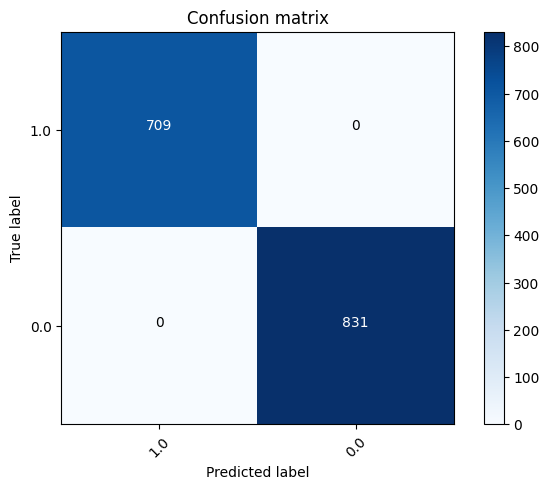

In [130]:
predictions = dtModel.transform(test)
#predictions_train = dtModel.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10, False)
evaluate_prediction(predictions)

+-----+-------------+----------+-----------+
|label|rawPrediction|prediction|probability|
+-----+-------------+----------+-----------+
|0.0  |[64.0,0.0]   |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
|0.0  |[3952.0,0.0] |0.0       |[1.0,0.0]  |
+-----+-------------+----------+-----------+
only showing top 10 rows

Confusion matrix, without normalization
[[709   0]
 [  0 831]]


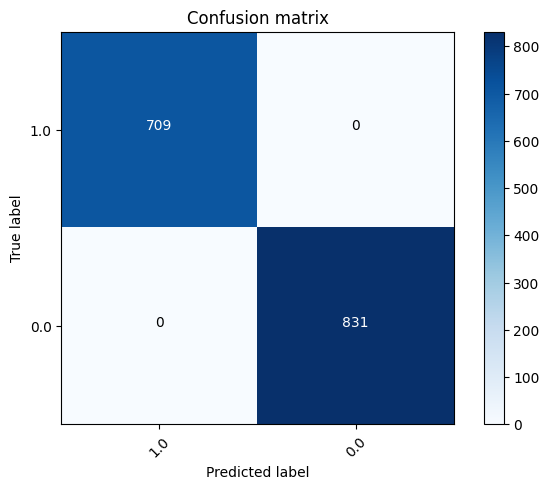

In [113]:
# dtModel.save('mushrooms_renamed_dt')
persistedModel = DecisionTreeClassificationModel.load('mushrooms_renamed_dt')
predictions = persistedModel.transform(test)
#predictions_train = dtModel.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10, False)
evaluate_prediction(predictions)

# Test avec la pipeline inclus dans le modèle

In [160]:
def convert_label(label):
    return 1 if label == "p" else 0

convert_label_udf = F.udf(convert_label, IntegerType()) 

In [162]:
# features = [ i for i in df_prepared.columns if i != "label"]
df = spark.read.csv('mushrooms.csv',header=True,inferSchema=True)
df = (df
      .withColumnRenamed('class', 'label')
      .withColumnRenamed('cap-shape', 'cap_shape')
      .withColumnRenamed('cap-surface', 'cap_surface')
      .withColumnRenamed('cap-color', 'cap_color')
      .withColumnRenamed('gill-attachment', 'gill_attachment')
      .withColumnRenamed('gill-spacing', 'gill_spacing')
      .withColumnRenamed('gill-size', 'gill_size')
      .withColumnRenamed('gill-color', 'gill_color')
      .withColumnRenamed('stalk-shape', 'stalk_shape')
      .withColumnRenamed('stalk-root', 'stalk_root')
      .withColumnRenamed('stalk-surface-above-ring', 'stalk_surface_above_ring')
      .withColumnRenamed('stalk-surface-below-ring', 'stalk_surface_below_ring')
      .withColumnRenamed('stalk-color-above-ring', 'stalk_color_above_ring')
      .withColumnRenamed('stalk-color-below-ring', 'stalk_color_below_ring')
      .withColumnRenamed('veil-type', 'veil_type')
      .withColumnRenamed('veil-color', 'veil_color')
      .withColumnRenamed('ring-number', 'ring_number')
      .withColumnRenamed('ring-type', 'ring_type')
      .withColumnRenamed('spore-print-color', 'spore_print_color')
      .withColumn('label', convert_label_udf('label'))
)
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns ] 
vectorizor = (VectorAssembler()
             .setInputCols(features)
             .setOutputCol("vectorized_features"))

dt = DecisionTreeClassifier(featuresCol = 'vectorized_features', labelCol = 'label', maxDepth=10)
pipeline = Pipeline(stages=[*indexers, vectorizor, dt ])


(train, test) = df.randomSplit([0.8, 0.2], seed = 2)
print('size train: ', train.count(), 'size_test ', test.count())

model = pipeline.fit(train)

# model.save('mushrooms_pipelined')

predictions = model.transform(test)


size train:  6584 size_test  1540


+-----+-------------+----------+-----------+
|label|rawPrediction|prediction|probability|
+-----+-------------+----------+-----------+
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
|0    |[3160.0,0.0] |0.0       |[1.0,0.0]  |
+-----+-------------+----------+-----------+
only showing top 10 rows

Confusion matrix, without normalization
[[709   0]
 [  0 831]]


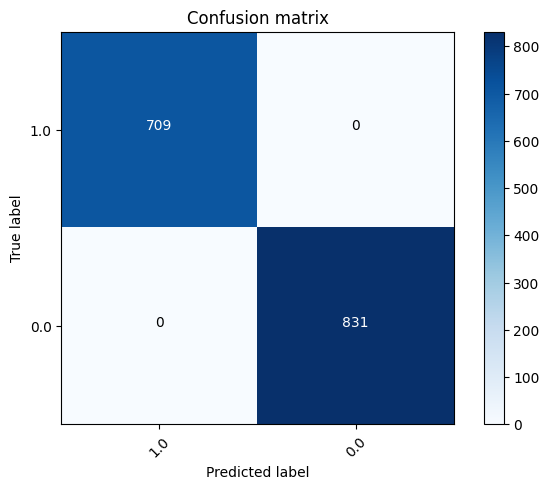

In [166]:
persistedModel = PipelineModel.load('pipelined_mushrooms')
predictions = persistedModel.transform(test)
#predictions_train = dtModel.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10, False)
evaluate_prediction(predictions)